## Declarations

### Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

import tensorflow_hub as hub
import tensorflow_text as text

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.13.0
Num GPUs Available:  1


### Constants

In [18]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Turn ON for kaggle filepaths
kaggle = False

kaggle1 = "/kaggle/input/transformers-hackathon/"
kaggle2 = "/kaggle/input/transformers-hackathon-features/"

image_dir = "./resized_train"
caption_pred_file = "caption_prediction_train.csv"
concept_det_file = "concept_detection_train.csv"
concept_file = "concepts.csv"

if kaggle:
    image_dir = kaggle1 + image_dir
    caption_pred_file = kaggle2 + caption_pred_file
    concept_det_file = kaggle2 + concept_det_file
    concept_file = kaggle2 + concept_file

image_size = (128, 128, 3)

batch_size = 10
pretrain_batch_size = 32

pretrain_epochs = 5
epochs_phase1 = 50
epochs_phase2 = 50

## Preprocessing

In [3]:
feature_types = {'image': tf.float16, 'caption': tf.string, 'concepts': tf.bool, 'raw caption': tf.string, 'image path': tf.string}
feature_shapes = {'image': (128, 128, 3), 'caption': (), 'concepts': (8374)}
base_features = ["image", "caption"]

In [4]:
concepts = pd.read_csv(concept_file, sep='\t')
concept_list = concepts.set_index('concept')['concept_name'].to_dict()
# Concept one-hot encoder
concepts_onehot = MultiLabelBinarizer(classes = list(concept_list.keys()))
concepts_onehot.fit([list(concept_list.keys())])

captions = pd.read_csv(caption_pred_file, sep='\t')
captions = captions.set_index('ID')['caption'].to_dict()

concepts = pd.read_csv(concept_det_file, sep='\t')
concepts = concepts.set_index('ID')['cuis'].to_dict()
concepts = {id: item_concepts.split(";") for id, item_concepts in concepts.items()}

In [5]:
def split(x, test_size=0.2, val_size=0.0, seed=0):
    if val_size + test_size >= 1:
        return None
    x_train, x_test = train_test_split(
        x, test_size=test_size + val_size, random_state=seed
    )
    x_val = None
    if val_size > 0:
        x_test, x_val = train_test_split(
            x_test,
            test_size=val_size / (test_size + val_size),
            random_state=seed,
        )
    return x_train, x_val, x_test

def load_image_from_path(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3, dct_method="INTEGER_ACCURATE")

    # may need resizing
    #image = tf.image.resize(image, image_shape[:2])
    image = tf.cast(image, dtype=tf.float16)
    image = image / 255.0
    return image

In [8]:
result = ""
for i in captions.values():
    result += " " + i
result = tf.strings.as_string(result)
result = bytes.decode(result.numpy())
vocab_size = len(set(result.split()))
print("Vocab size:")
print(vocab_size)

longest = max(captions.values(), key=len)
longest = tf.strings.as_string(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
sequence_length = len(longest)
print("Longest sequence:")
print(sequence_length)

concept_size = max([len(c) for _, c in concepts.items()])
print("Max number of concepts:")
print(concept_size)

Vocab size:
35489
Longest sequence:
391
Max number of concepts:
50


In [9]:
def load_features(image_folder, captions_file, concepts_file, concept_encoder, filter_percent=1):
    features = []
    
    # Import CSVs
    csv_caption_dataset = tf.data.experimental.CsvDataset(
        captions_file,
        field_delim='\t',
        record_defaults=[tf.string, tf.string],
        header=True,
        select_cols=[0, 1]
    )
    csv_concept_dataset = tf.data.experimental.CsvDataset(
        concepts_file,
        field_delim='\t',
        record_defaults=[tf.string, tf.string],
        header=True,
        select_cols=[0, 1]
    )
    
    # We make the assumption that CSV files contain the same key values (image names)
    # following the same ordering

    # Extract features from dataset
    print("Extracting features from CSV file(s)")
    for caption_el, concept_el in tqdm(zip(csv_caption_dataset, csv_concept_dataset)):
        filename_cap, caption = caption_el
        filename_con , concepts = concept_el
        
        # Sanity check
        assert filename_cap == filename_con
        
        image_path = image_dir + "/" + filename_cap + ".jpg"
        
        features.append({
            'caption': caption,
            'image path': image_path,
            'concepts': concept_encoder.transform([concepts.numpy().decode("utf-8").split(";")]),
        })
        
    # Filter elements
    if filter_percent != 1:
        n_features = int(len(features) * filter_percent)
        features = random.sample(features, n_features)
        
    return features

def preprocess_features(features, concept_encoder, filter_percent=1):
    print("Preprocessing features")
    
    # Filter elements
    if filter_percent != 1:
        n_features = int(len(features) * filter_percent)
        features = random.sample(features, n_features)
        
    return {
        'image paths': tf.convert_to_tensor([x["image path"] for x in tqdm(features)], dtype=tf.string),
        'captions': tf.convert_to_tensor([x["caption"] for x in tqdm(features)], dtype=tf.string),
        'concepts': tf.convert_to_tensor(np.vstack([concept_encoder.transform(x["concepts"]).flatten() for x in tqdm(features)]), dtype=tf.bool),
        # 'images': tf.convert_to_tensor([load_image(x["image path"]) for x in tqdm(features)], dtype=tf.float16),
    }

In [10]:
# Load dataset features from csv files, split them and preprocess them
features = load_features(image_dir, caption_pred_file, concept_det_file, concepts_onehot, filter_percent=1)
feat_train, feat_val, feat_test = split(features, test_size=0.2, val_size=0.0, seed=seed)

Extracting features from CSV file(s)


83275it [00:42, 1950.24it/s]


In [11]:
def create_dataset(
        features, 
        input_features_types,
        feature_shapes,
        x_features, y_features=None, 
        x_dict=True, y_dict=True,
        load_images=True, 
        shuffle_buffer_size=1024, 
        batch_size=10, 
        cached=False
):
    # Generate dataset following initial input feature types
    dataset = tf.data.Dataset.from_generator(
        lambda: features, { x: input_features_types[x] for x in input_features_types }
    )
    
    # Preprocessing internal functions
    def setshape(e):
        for (k, v) in feature_shapes.items():
            if k in e:
                e[k].set_shape(v)
        return e
    def add_images(e):
        # Maybe parametrize
        img_from = "image path"
        img_to = "image"
        new_features = list(input_features_types.keys()) + [img_to]
        return {f:e[f] if f != img_to else load_image_from_path(e[img_from]) for f in new_features}
    def split_xy(e):
        e_x = {xf:tf.squeeze(e[xf]) for xf in x_features} if x_dict else tf.squeeze([e[xf] for xf in x_features])
        if y_features:
            e_y = {yf:tf.squeeze(e[yf]) for yf in y_features} if y_dict else tf.squeeze([e[yf] for yf in y_features])
            return (e_x, e_y)
        return e_x
    
    # Preprocess
    if load_images:
        dataset = dataset.map(add_images)
    dataset = dataset.map(setshape)
    dataset = dataset.map(split_xy)

    # Compile dataset
    if cached:
        dataset = dataset.cache()
    dataset = dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

def visualize_first_of_dataset_batch(dataset_batch, nums=5):
    for c in range(0, nums):
        i = tf.cast(dataset_batch["image"][c], dtype=tf.float32)
        t = dataset_batch["raw caption"][c]
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, c + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])
def visualize_first_of_dataset_batch(dataset_batch, nums=5):
    for c in range(0, nums):
        i = tf.cast(dataset_batch["image"][c], dtype=tf.float32)
        t = dataset_batch["raw caption"][c]
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, c + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])

In [13]:
in_feat_typ = {'caption': tf.string, 'concepts': tf.bool, 'image path': tf.string}
x_features = ['caption', 'image']
x_features_iep = ['image']
y_features_iep = ['concepts']

train_ds_size = len(feat_train) if feat_train else 0
val_ds_size = len(feat_val) if feat_val else 0
test_ds_size = len(feat_test) if feat_test else 0

train_dataset = create_dataset(feat_train, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features, batch_size=batch_size) if feat_train else None
val_dataset = create_dataset(feat_val, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features, batch_size=batch_size) if feat_val else None
test_dataset = create_dataset(feat_test, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features, batch_size=batch_size) if feat_test else None

train_dataset_iep = create_dataset(feat_train, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features_iep, y_features=y_features_iep, x_dict=False, y_dict=False, batch_size=pretrain_batch_size, cached=True) if feat_train else None
val_dataset_iep = create_dataset(feat_val, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features_iep, y_features=y_features_iep, x_dict=False, y_dict=False, batch_size=pretrain_batch_size, cached=True) if feat_val else None
test_dataset_iep = create_dataset(feat_test, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features_iep, y_features=y_features_iep, x_dict=False, y_dict=False, batch_size=pretrain_batch_size, cached=True) if feat_test else None

train_dataset_eval = create_dataset(feat_train, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=['image path', 'image'], y_features=['caption', 'concepts'], x_dict=True, y_dict=True, batch_size=1, shuffle_buffer_size=1)
test_dataset_eval = create_dataset(feat_test, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=['image path', 'image'], y_features=['caption', 'concepts'], x_dict=True, y_dict=True, batch_size=1, shuffle_buffer_size=1)

## Download Models

In [14]:
text_preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
        name="text_preprocessing",
    )

text_transformer = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        trainable=True,
        name="bert",
    )

img_preprocess = tfk.applications.convnext.preprocess_input

img_supernet = tfk.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
supernet_name = img_supernet.name

## Pre-training

In [15]:
def image_encoder_pretrainer(preprocessing, supernet, n_concepts, input_shape=(128,128,3), learning_rate=1e-5):
    
    input_layer = tfkl.Input(shape=input_shape, name='image')

    x = preprocessing(input_layer)
    x = supernet(x)
    
    x = tfkl.GlobalMaxPooling2D(name='GAP')(x)
    x = tfkl.Dense(256, activation='relu')(x)
    x = tfkl.Dense(128, activation='relu')(x)
    x = tfkl.Dense(n_concepts, activation="sigmoid", name='output')(x)

    image_encoder_pretrainer = tfk.Model(inputs=input_layer, outputs=x, name="image_encoder_pretrainer")
    image_encoder_pretrainer.compile(
        loss="binary_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    )
    
    return image_encoder_pretrainer

In [21]:
iep = image_encoder_pretrainer(img_preprocess, img_supernet, len(concept_list.keys()))

In [22]:
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)

history = iep.fit(
    train_dataset_iep,
    epochs = pretrain_epochs,
    validation_data = test_dataset_iep,
    callbacks = [early_stopping],
)

Epoch 1/5


2082/2082 [==============================] - 223s 96ms/step - loss: 0.0619 - val_loss: 0.0036
Epoch 2/5
2082/2082 [==============================] - 199s 96ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 3/5
2082/2082 [==============================] - 198s 95ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/5
2082/2082 [==============================] - 199s 95ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 5/5
2082/2082 [==============================] - 199s 95ms/step - loss: 0.0034 - val_loss: 0.0034


In [23]:
img_supernet = iep.layers[1]

## Network

### Network blocks

In [24]:
def projection(embedding_input, embed_dim, name):
    
    embeddings = tfkl.Dense(embed_dim, name=f'{name}_1')(embedding_input)
    x = tf.nn.selu(embeddings)
    x = tfkl.Dense(embed_dim, name=f'{name}_2')(x)
    x = tfkl.Dropout(0.1)(x)
    x = tfkl.Add()([x, embeddings])
    embeddings = tfkl.LayerNormalization()(x)

    return embeddings

In [25]:
def image_encoder(input_shape, embed_dim, seed=42, supernet=None, preprocessing=None):
    
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='img_input_layer')
    x = preprocessing(input_layer)
    x = supernet(x)
    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)

    x = projection(x, embed_dim, 'img_embedding_dense_layer')
    
    # Connect input and output through the Model class
    cnn_encoder = tfk.Model(inputs=input_layer, outputs=x, name='image_encoder')

    # Return the encoder
    return cnn_encoder

In [26]:
def text_encoder(embed_dim, preprocess, transformer, trainable=True):

    transformer.trainable = trainable
    
    input_layer = tfkl.Input(shape=(), dtype=tf.string, name="text_input")
    x = preprocess(input_layer)
    x = transformer(x)["pooled_output"]
    x = projection(x, embed_dim, 'txt_embedding_dense_layer')

    text_encoder = tfk.Model(inputs=input_layer, outputs=x, name="text_encoder")
    
    return text_encoder

In [31]:
class CLIP(tfk.Model):
    def __init__(self, image_encoder, text_encoder, **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.loss_tracker = tfk.metrics.Mean(name="loss")
        self.temp = self.add_weight(name='t',
                                 shape=(1, ),
                                 initializer=tfk.initializers.Constant(1.),
                                 trainable=True)

        self.call_model()

        
    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        image_emb = self.image_encoder(features["image"], training=training)
        text_emb = self.text_encoder(features["caption"], training=training)
        return image_emb, text_emb

    def CLIP_loss(self, image_emb, text_emb):
        norm_image_emb = tf.math.l2_normalize(image_emb, axis=1)
        norm_text_emb = tf.math.l2_normalize(text_emb, axis=1)

        logits = tf.linalg.matmul(norm_image_emb, norm_text_emb, transpose_b=True) * tf.math.exp(self.temp)

        n = tf.shape(logits)[0]
        labels = tf.range(n)

        labels = tf.one_hot(labels, n)

        loss_img = tfk.losses.categorical_crossentropy(labels, logits, from_logits=True)
        loss_txt = tfk.losses.categorical_crossentropy(labels, kb.transpose(logits), from_logits=True)

        return (loss_img + loss_txt) / tf.constant(2.0)

    def train_step(self, features):
        with tf.GradientTape() as tape:
            image_embeddings, caption_embeddings = self(features, training=True)
            loss = self.CLIP_loss(caption_embeddings, image_embeddings)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        image_embeddings, caption_embeddings = self(features, training=False)
        loss = self.CLIP_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def call_model(self):

        image = tf.reshape(tf.convert_to_tensor(np.zeros((128,128,3))), (1,128,128,3))
        caption = tf.convert_to_tensor(["Hello there"], dtype=tf.string)

        sample = {"image": image, "caption": caption}

        self(sample)

    def summary(self):
        super().summary()

        print("\n")
        self.image_encoder.summary()

        print("\n")
        self.text_encoder.summary()

### Building network

In [32]:
def build_clip(img_supernet,
               img_preprocess,
               text_transformer,
               text_preprocess,
               img_input_shape=(128,128,3),
               txt_input_shape=(393, ), 
               embed_dim=64, 
               learning_rate=2e-5):

    
    text_encoder_model = text_encoder(embed_dim, text_preprocess, text_transformer)
    image_encoder_model = image_encoder(img_input_shape, embed_dim, supernet=img_supernet, preprocessing=img_preprocess)

    clip = CLIP(image_encoder_model, text_encoder_model)
    clip.compile(optimizer = tf.optimizers.AdamW(learning_rate=learning_rate))

    return image_encoder_model, text_encoder_model, clip

In [33]:
clip_image_encoder, clip_text_encoder, clip = build_clip(img_supernet, img_preprocess, text_transformer, text_preprocess)

In [34]:
clip.summary()

Model: "clip_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_encoder (Functional)  (None, 64)                27873632  
                                                                 
 text_encoder (Functional)   (None, 64)                28800769  
                                                                 
Total params: 56674404 (216.20 MB)
Trainable params: 56674401 (216.20 MB)
Non-trainable params: 3 (9.00 Byte)
_________________________________________________________________


Model: "image_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_input_layer (InputLaye  [(None, 128, 128, 3)]        0         []                            
 r)                                                                                       

## Training

### Phase 1
Traning all the parameters

In [36]:
# Create a learning rate scheduler callback.
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor = "val_loss", factor = 0.2, patience = 3
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)

history_phase1 = clip.fit(
    train_dataset,
    epochs = epochs_phase1,
    validation_data = test_dataset,
    callbacks = [reduce_lr, early_stopping],
)

Epoch 1/50


6662/6662 [==============================] - 523s 74ms/step - loss: 1.5675 - val_loss: 1.2509 - lr: 2.0000e-05
Epoch 2/50
6662/6662 [==============================] - 470s 70ms/step - loss: 1.0992 - val_loss: 1.0255 - lr: 2.0000e-05
Epoch 3/50
6662/6662 [==============================] - 469s 70ms/step - loss: 0.8971 - val_loss: 0.9199 - lr: 2.0000e-05
Epoch 4/50
6662/6662 [==============================] - 461s 69ms/step - loss: 0.7505 - val_loss: 0.8137 - lr: 2.0000e-05
Epoch 5/50
6662/6662 [==============================] - 465s 70ms/step - loss: 0.6338 - val_loss: 0.7729 - lr: 2.0000e-05
Epoch 6/50
6662/6662 [==============================] - 465s 70ms/step - loss: 0.5317 - val_loss: 0.7363 - lr: 2.0000e-05
Epoch 7/50
6662/6662 [==============================] - 462s 69ms/step - loss: 0.4563 - val_loss: 0.7276 - lr: 2.0000e-05
Epoch 8/50
6662/6662 [==============================] - 463s 69ms/step - loss: 0.3948 - val_loss: 0.7402 - lr: 2.0000e-05
Epoch 9/50
6662/6662 [=============

### Phase 2
Training the projection only

In [37]:
img_supernet.trainable = False
text_transformer.trainable = False

In [38]:
clip.compile(optimizer = tf.optimizers.AdamW(2e-5))

In [39]:
# Create a learning rate scheduler callback.
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor = "val_loss", factor = 0.2, patience = 3
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)

history_phase2 = clip.fit(
    train_dataset,
    epochs = 50,
    validation_data = test_dataset,
    callbacks = [early_stopping, reduce_lr],
)

Epoch 1/50
6662/6662 [==============================] - 190s 27ms/step - loss: 0.3991 - val_loss: 0.7054 - lr: 2.0000e-05
Epoch 2/50
6662/6662 [==============================] - 182s 27ms/step - loss: 0.3723 - val_loss: 0.7123 - lr: 2.0000e-05
Epoch 3/50
6662/6662 [==============================] - 181s 27ms/step - loss: 0.3615 - val_loss: 0.7243 - lr: 2.0000e-05
Epoch 4/50
6662/6662 [==============================] - 181s 27ms/step - loss: 0.3513 - val_loss: 0.7331 - lr: 2.0000e-05
Epoch 5/50
6662/6662 [==============================] - 181s 27ms/step - loss: 0.3473 - val_loss: 0.7204 - lr: 4.0000e-06
Epoch 6/50
6662/6662 [==============================] - 181s 27ms/step - loss: 0.3438 - val_loss: 0.7255 - lr: 4.0000e-06


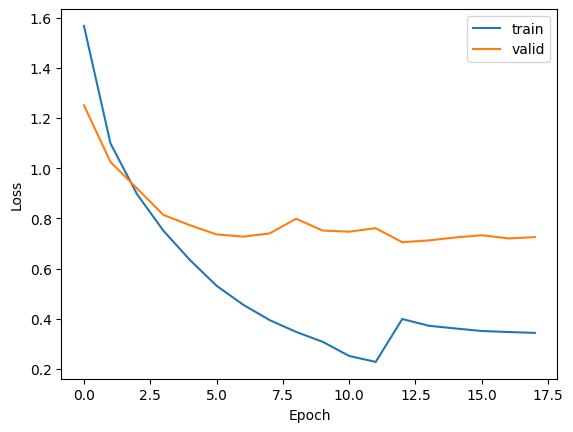

In [40]:
plt.plot(history_phase1.history["loss"]+history_phase2.history["loss"])
plt.plot(history_phase1.history["val_loss"]+history_phase2.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

### Save model weights

In [41]:
clip.save_weights('clip_weights.h5')

### Task performance

In [42]:
def generate_image_embeddings(
    image_encoder,                 # Image encoder of clip model
    dataset_eval,                  # Dataset to generate embeddings (WARNING: the dataset must not be shuffling or have a shuffle buffer size of 1)
    dataset_pred_map=lambda *x: x, # Lambda mapping function for prediction
    dataset_ref_map=lambda *x: x,  # Lambda mapping function for reference
):
    print("Generating image embeddings")
    image_embeddings = image_encoder.predict(
        dataset_eval.map(dataset_pred_map),
        verbose=1,
    )
    dataset_reference = [x for x in dataset_eval.map(dataset_ref_map).unbatch()]
    return dataset_reference, image_embeddings

def find_t2i_matches(
    queries,                # Queries to search
    text_encoder,           # Text encoder of clip model
    image_embeddings,       # Generated image embeddings
    dataset_reference=None, # Reference for retreived dataset elements following indices
    k=10,                    # Number of elements for top-k
    normalize=True,         # Embedding normalization
):
    print("Computing Text-to-Image matches")
    # Generate query dataset and get their embeddings
    queries_ds = tf.data.Dataset.from_tensor_slices(queries).batch(batch_size)
    query_embedding = text_encoder.predict(queries_ds)
    # Normalize the query and the image embeddings
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    return results

def index_to_reference(results, dataset_reference):
    return [[dataset_reference[match] for match in result] for result in results]

def visualize_t2i_results(matches):
    # Assuming matches are in the form of tuples: (image_path, caption)
    print("Top matches for query: \"" + query + "\"")
    plt.figure(figsize=(18, 18))
    for i in range(len(matches)):
        path = matches[i][0].numpy().decode('UTF-8')
        caption = matches[i][0].numpy()#.decode('UTF-8')
        print('Caption: '+path)
        #ax = plt.subplot(3, 3, i + 1)
        #plt.imshow(mpimg.imread(path))
        #plt.axis("off")
        print(f"{i}) {caption}")

In [43]:
# TODO: assumption that the whole dataset is used as a query for most metrics: **
def compute_relevant_at_k(results, dataset_reference, k=None, reference_preprocess=lambda x: x, relevance=lambda m, o: m == o):
    if not k:
        k = len(results[0])
    return [ 
        np.count_nonzero([relevance(match, original) for match in list(map(reference_preprocess, matches))[0:k]])
        for matches, original in zip(results, map(reference_preprocess, dataset_reference)) # **
    ]

def compute_total_relevance(dataset_reference, reference_preprocess=lambda x: x, relevance=lambda m, o: m == o):
    total_n = {}
    for element in map(reference_preprocess, dataset_reference):
        if element in total_n:
            total_n[element] += 1
        else:
            total_n[element] = 1
    return total_n

def compute_top_k_accuracy(results, dataset_reference, relevant_at_k=None, k=None, reference_preprocess=lambda x: x, relevance=lambda m, o: m == o):
    if not relevant_at_k:
        relevant_at_k = compute_relevant_at_k(results, dataset_reference, k, reference_preprocess=reference_preprocess, relevance=relevance)
    hits = np.count_nonzero(relevant_at_k)
    return hits / len(dataset_reference)

def compute_map_k(results, dataset_reference, relevant_at_k=None, k=None, reference_preprocess=lambda x: x, relevance=lambda m, o: m == o):
    if not k:
        k = len(results[0])
    if not relevant_at_k:
        relevant_at_k = compute_relevant_at_k(results, dataset_reference, k, reference_preprocess=reference_preprocess, relevance=relevance)
    precision_at_k = [r/k for r in relevant_at_k]
    return np.sum(precision_at_k) / len(dataset_reference)

def compute_mar_k(results, dataset_reference, relevant_at_k=None, total_relevant=None, k=None, reference_preprocess=lambda x: x, relevance=lambda m, o: m == o):
    if not k:
        k = len(results[0])
    if not relevant_at_k:
        relevant_at_k = compute_relevant_at_k(results, dataset_reference, k, reference_preprocess=reference_preprocess, relevance=relevance)
    if not total_relevant_at_k:
        total_relevant = compute_total_relevance(results, dataset_reference, reference_preprocess=reference_preprocess, relevance=relevance)
    recall_at_k = [rk/tr for rk, tr in zip(relevant_at_k, total_relevant)] # **
    return np.sum(recall_at_k) / len(dataset_reference)

In [44]:
k = 5
concept_overlap_threshold = 2
reference_preprocess_cap = lambda x: x[0].numpy().decode('UTF-8')                                    # Function to preprocess data when we want to evaluate captions
reference_preprocess_con = lambda x: x[1]                                                            # Function to preprocess data when we want to evaluate concepts
concept_relevance = lambda m, o: np.count_nonzero(np.logical_and(m, o)) >= concept_overlap_threshold # Function to compute if a match is relevant given concept arrays 

'''
print("### Scoring training data ###")
train_dataset_reference, train_image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    train_dataset_eval,
    dataset_pred_map=lambda x, y: x['image'],
    dataset_ref_map=lambda x, y: (y['caption'], y['concepts'])
)
train_queries = [e[0] for e in train_dataset_reference]
# Compute relevance for all the queries in the dataset using only caption equality as a metric
train_tot_relevant = compute_total_relevance(train_dataset_reference, reference_preprocess=reference_preprocess_cap)
# Compute matching results and extrapolate relevant matches based on different criterions
train_raw_results = find_t2i_matches(train_queries, clip_text_encoder, train_image_embeddings, k=k, normalize=True)
train_results = index_to_reference(train_raw_results, train_dataset_reference)
train_relevant_cap = compute_relevant_at_k(train_results, train_dataset_reference, reference_preprocess=reference_preprocess_cap)
train_relevant_con = compute_relevant_at_k(train_results, train_dataset_reference, reference_preprocess=reference_preprocess_con, relevance=concept_relevance)
'''

print("\n### Scoring test data ###")
test_dataset_reference, test_image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    test_dataset_eval,
    dataset_pred_map=lambda x, y: x['image'],
    dataset_ref_map=lambda x, y: (y['caption'], y['concepts'])
)
test_queries = [e[0] for e in test_dataset_reference]
# Compute relevance for all the queries in the dataset using only caption equality as a metric
test_tot_relevant = compute_total_relevance(test_dataset_reference, reference_preprocess=reference_preprocess_cap)
# Compute matching results and extrapolate relevant matches based on different criterions
test_raw_results = find_t2i_matches(test_queries, clip_text_encoder, test_image_embeddings, k=k, normalize=True)
test_results = index_to_reference(test_raw_results, test_dataset_reference)
test_relevant_cap = compute_relevant_at_k(test_results, test_dataset_reference, reference_preprocess=reference_preprocess_cap)
test_relevant_con = compute_relevant_at_k(test_results, test_dataset_reference, reference_preprocess=reference_preprocess_con, relevance=concept_relevance)


### Scoring test data ###
Generating image embeddings
16655/16655 [==============================] - 257s 15ms/step
Computing Text-to-Image matches
1666/1666 [==============================] - 15s 9ms/step


In [45]:
'''
print("### Training data ###")
train_accuracy_cap = compute_top_k_accuracy(train_results, train_dataset_reference, relevant_at_k=train_relevant_cap)
train_accuracy_con = compute_top_k_accuracy(train_results, train_dataset_reference, relevant_at_k=train_relevant_con)
print(f"Accuracy for caption equality: {round(train_accuracy_cap * 100, 3)}%")
print(f"Accuracy for concept overlap: {round(train_accuracy_con * 100, 3)}%")
train_map_cap = compute_map_k(train_results, train_dataset_reference, relevant_at_k=train_relevant_cap)
train_map_con = compute_map_k(train_results, train_dataset_reference, relevant_at_k=train_relevant_con)
print(f"Mean Average Precision for caption equality: {round(train_map_cap * 100, 3)}%")
print(f"Mean Average Precision for concept overlap: {round(train_map_con * 100, 3)}%")
'''

print("\n### Test data ###")
test_accuracy_cap = compute_top_k_accuracy(test_results, test_dataset_reference, relevant_at_k=test_relevant_cap)
test_accuracy_con = compute_top_k_accuracy(test_results, test_dataset_reference, relevant_at_k=test_relevant_con)
print(f"Accuracy for caption equality: {round(test_accuracy_cap * 100, 3)}%")
print(f"Accuracy for concept overlap: {round(test_accuracy_con * 100, 3)}%")
test_map_cap = compute_map_k(test_results, test_dataset_reference, relevant_at_k=test_relevant_cap)
test_map_con = compute_map_k(test_results, test_dataset_reference, relevant_at_k=test_relevant_con)
print(f"Mean Average Precision for caption equality: {round(test_map_cap * 100, 3)}%")
print(f"Mean Average Precision for concept overlap: {round(test_map_con * 100, 3)}%")


### Test data ###
Accuracy for caption equality: 1.513%
Accuracy for concept overlap: 44.947%
Mean Average Precision for caption equality: 0.305%
Mean Average Precision for concept overlap: 22.417%


In [46]:
query = "brain"
# WARNING: currently using train_dataset_eval
'''
dataset_reference, image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    train_dataset_eval,
    dataset_pred_map=lambda x, y: x['image'],
    dataset_ref_map=lambda x, y: (x['image path'], y['caption'])
) '''
results = find_t2i_matches([query], clip_text_encoder, test_image_embeddings, k=5, normalize=False)
results = index_to_reference(results, test_dataset_reference)
for matches in results:
    visualize_t2i_results(matches)

Computing Text-to-Image matches
1/1 [==============================] - 0s 11ms/step
Top matches for query: "brain"
Caption: a  male patient with  with bilateral thalamic involvement in brain imaging
0) b'a  male patient with  with bilateral thalamic involvement in brain imaging'
Caption: mri take one month postoperatively
1) b'mri take one month postoperatively'
Caption: axial  weighted image show hypointensity of the genu white arrow and splenium white arrowhead of corpus callosum
2) b'axial  weighted image show hypointensity of the genu white arrow and splenium white arrowhead of corpus callosum'
Caption: magnetic resonance imaging axial  image show a heterogeneously hyperintense lesion with multiple flow void
3) b'magnetic resonance imaging axial  image show a heterogeneously hyperintense lesion with multiple flow void'
Caption: contrast enhancement magnetic resonance imaging scan of case
4) b'contrast enhancement magnetic resonance imaging scan of case'


<Figure size 1800x1800 with 0 Axes>